In [25]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error as rmse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [26]:
data = pd.read_csv("flight_data.csv")
data.head()
data.drop(columns="Unnamed: 0", axis=1, inplace=True)

print(data.info())
print(data.describe())
print(data["class"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB
None
            duration      days_left          price
count  300153.000000  300153.000000  300153.000000
mean       12.221021      26.004751   20889.660523
std         7.191997      13.561004   22697.

In [27]:
data = data.drop(["flight"], axis = 1)
print(data.columns)

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left', 'price'],
      dtype='object')


In [28]:


df_numeric = data.select_dtypes(include=['int64','float64'])
print(df_numeric.shape)

data.to_csv("engineered_data.csv")

(300153, 3)


In [29]:
X = data.drop(["price"], axis = 1)
y = data["price"]
print(X.shape, y.shape)

(300153, 9) (300153,)


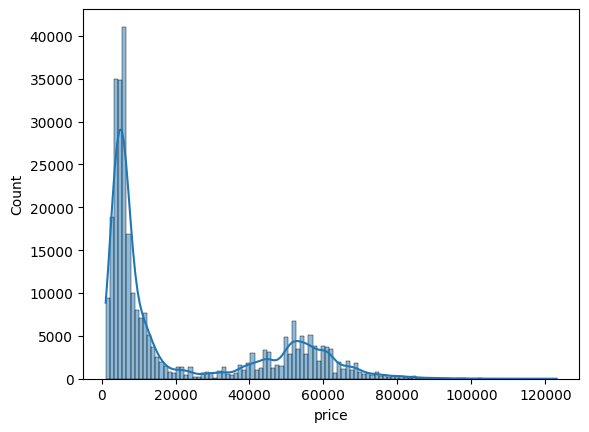

In [30]:
sns.histplot(data=df_numeric, x="price", kde=True)
plt.show()

In [31]:
categorical = (X.select_dtypes(include = ["object"]).drop(["class", "stops"], axis = 1)).columns.tolist()
ordinal = ["class","stops"]
ordinal_categories = [
    ['Economy', 'Business'],
    ['zero', 'one', 'two_or_more']
]
numerical = df_numeric.drop("price", axis=1).columns.tolist()
print(categorical, ordinal, numerical)

['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city'] ['class', 'stops'] ['duration', 'days_left']


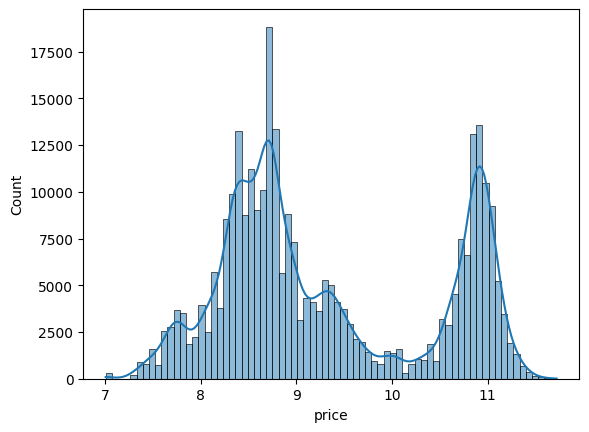

In [32]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

y_log = log_transformer.transform(y)

sns.histplot(data = y_log, kde=True)
plt.show()


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("ord", OrdinalEncoder(categories=ordinal_categories), ordinal),
        ("num", "passthrough", numerical),
    ]
)


In [34]:
print(X_train.columns.tolist())

['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left']


In [35]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline

# Define the model
lgb_reg = lgb.LGBMRegressor(
    n_estimators=2000,      # set a high number
    learning_rate=0.05,
    max_depth=-1,
    random_state=578
)

# Add early stopping via callbacks
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True)]

pipeline = TransformedTargetRegressor(
    regressor=Pipeline([
        ("preprocessor", preprocessor),
        ("model", lgb_reg)
    ]),
    transformer=FunctionTransformer(np.log1p, inverse_func=np.expm1)
)

# Fit the pipeline
pipeline.fit(
    X_train, y_train
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 34
[LightGBM] [Info] Start training from score 9.330749


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('cat',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       ['airline',
                                                                                        'source_city',
                                                                                        'departure_time',
                                                                                        'arrival_time',
                                                                                        'destination_city']),
                                                                                      ('ord',
                                                                                       OrdinalEncoder(categories=[['Economy',
                                                                                                                   'Business'],
                                                                                                                  ['zero',
                                                                                                                   'one',
                                                                                                                   'two_or_more']]),
                                                                                       ['class',
                                                                                        'stops']),
                                                                                      ('num',
                                                                                       'passthrough',
                                                                                       ['duration',
                                                                                        'days_left'])])),
                                                     ('model',
                                                      LGBMRegressor(learning_rate=0.05,
                                                                    n_estimators=2000,
                                                                    random_state=578))]),
                           transformer=FunctionTransformer(func=<ufunc 'log1p'>,
                                                           inverse_func=<ufunc 'expm1'>))

In [36]:
y_pred = pipeline.predict(X_test)

rmse_lgb = rmse(y_test, y_pred)
print(f"The model achieved RMSE: {rmse_lgb:.4f}")





/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


The model achieved RMSE: 3438.7329


In [37]:
r2_lgb = r2_score(y_test, y_pred)
print(f"The model achieved R^2 score: {r2_lgb:.4f}")

The model achieved R^2 score: 0.9771


In [38]:
import joblib

# Save preprocessing object
joblib.dump(preprocessor, "preprocessor.pkl")

# Save trained model
joblib.dump(lgb_reg, "lgb_model.pkl")

joblib.dump(pipeline, "pipeline.pkl")

['pipeline.pkl']

Residual mean: 237.6267223022459
Residual std: 3430.541335170821


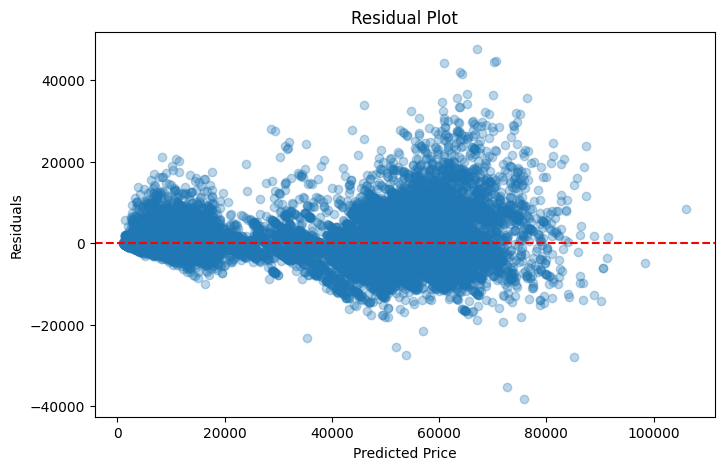

In [39]:
residuals = y_test - y_pred
print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())

# Plot residuals
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [40]:
import pandas as pd

# Make sure X_test is a DataFrame (not a NumPy array)
X_test_df = X_test.copy()

# Create DataFrame with predictions and residuals
comparison = pd.concat([
    X_test_df.reset_index(drop=True),
    pd.DataFrame({
        "True Price": y_test.reset_index(drop=True),
        "Predicted Price": y_pred,
        "Residual": y_test.reset_index(drop=True) - y_pred
    })
], axis=1)

# Show first 10 rows
comparison.tail(20)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,True Price,Predicted Price,Residual
60011,Air_India,Chennai,Morning,one,Morning,Bangalore,Economy,26.67,42,5012,4771.767106,240.232894
60012,Indigo,Kolkata,Evening,one,Night,Delhi,Economy,4.58,42,2994,3548.826489,-554.826489
60013,Vistara,Bangalore,Early_Morning,one,Evening,Hyderabad,Economy,10.33,39,6186,5714.596366,471.403634
60014,Air_India,Delhi,Morning,one,Evening,Mumbai,Economy,7.25,12,11341,12296.499538,-955.499538
60015,Air_India,Delhi,Evening,one,Evening,Bangalore,Economy,26.42,11,13231,11998.369060,1232.630940
60016,Air_India,Bangalore,Evening,one,Morning,Mumbai,Economy,16.83,12,9277,9853.085293,-576.085293
60017,Air_India,Bangalore,Evening,one,Morning,Mumbai,Economy,13.33,42,3961,5197.711592,-1236.711592
60018,GO_FIRST,Mumbai,Afternoon,one,Night,Kolkata,Economy,9.83,44,4961,5645.027174,-684.027174
60019,Air_India,Bangalore,Early_Morning,one,Evening,Mumbai,Business,10.92,24,39623,51137.067976,-11514.067976
60020,Indigo,Chennai,Afternoon,one,Night,Hyderabad,Economy,7.00,33,3280,1525.240491,1754.759509


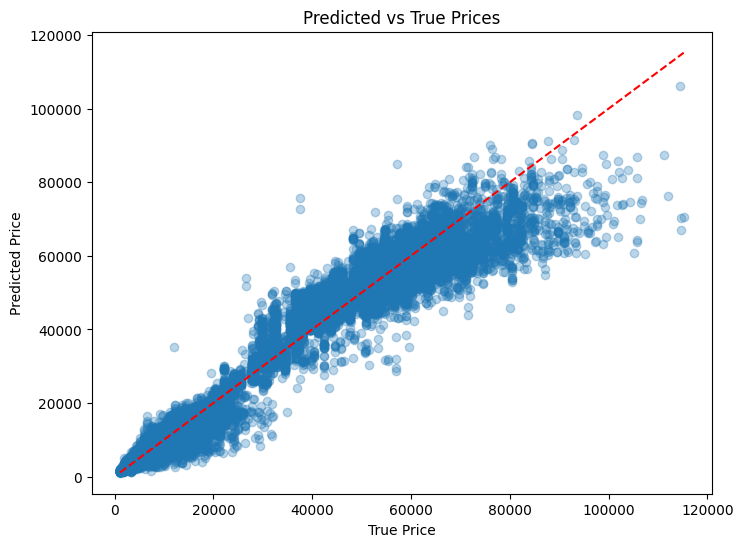

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs True Prices")
plt.show()

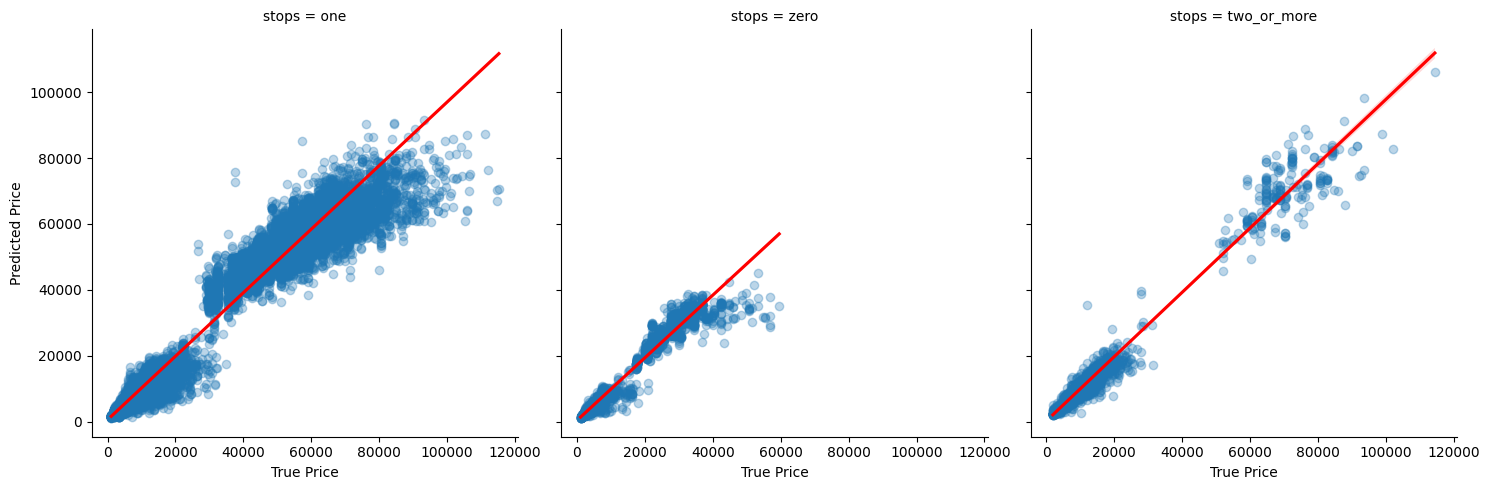

In [42]:
sns.lmplot(data = comparison, x = "True Price", y = "Predicted Price", scatter_kws={"alpha": 0.3}, line_kws={"color": "r"}, col= "stops")

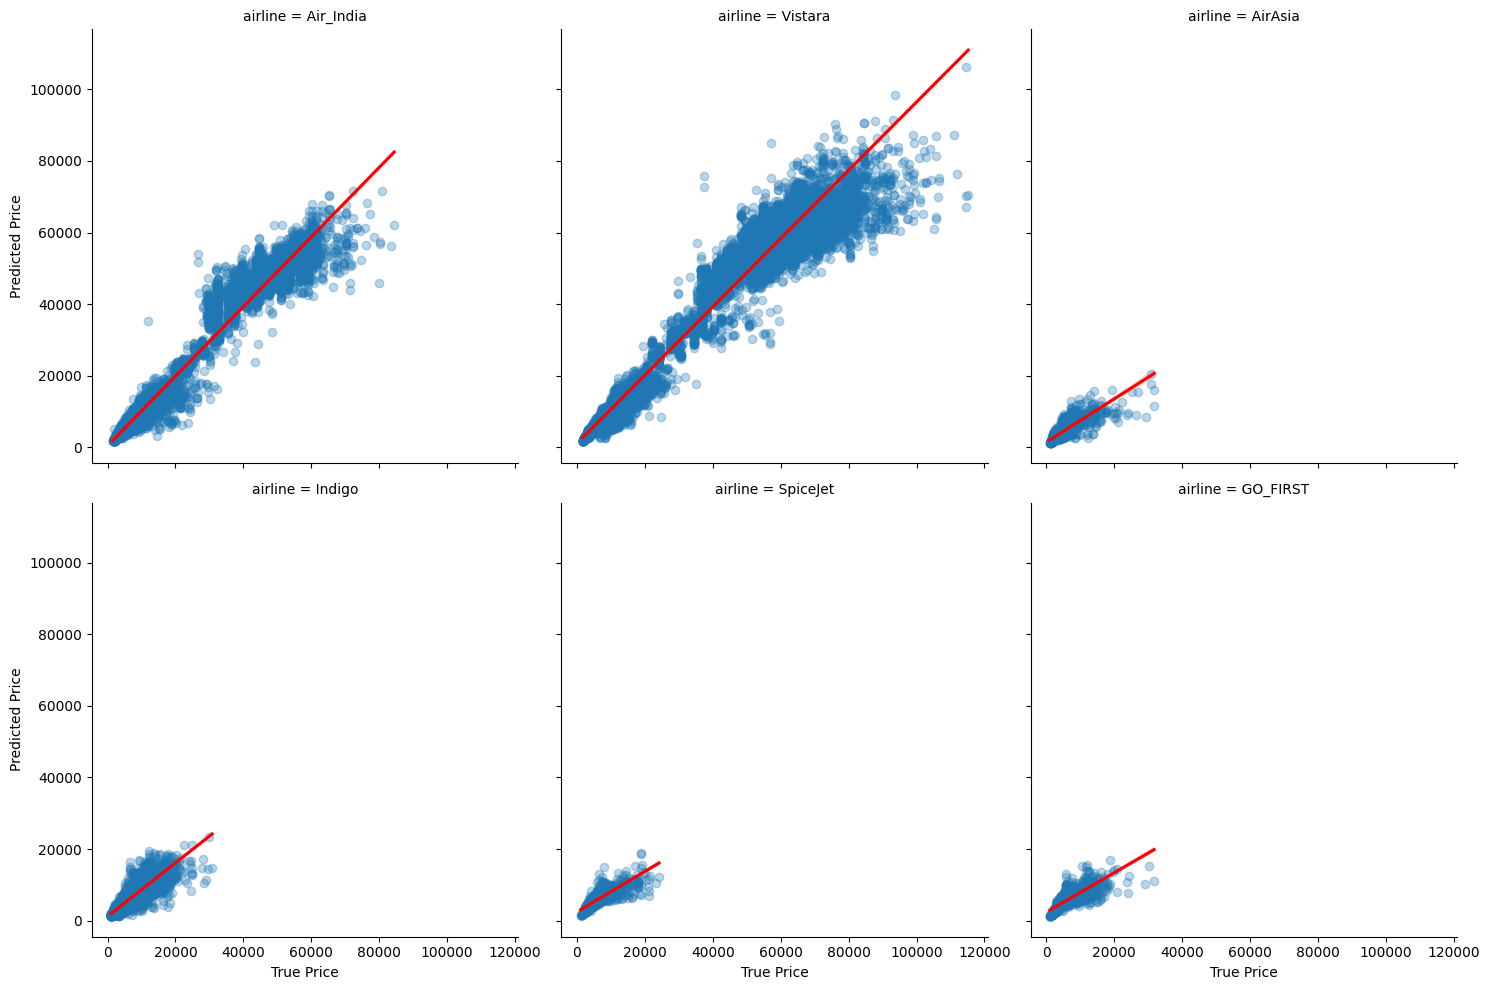

In [43]:
sns.lmplot(data = comparison, x = "True Price", y = "Predicted Price", scatter_kws={"alpha": 0.3}, line_kws={"color": "r"}, col= "airline", col_wrap=3)

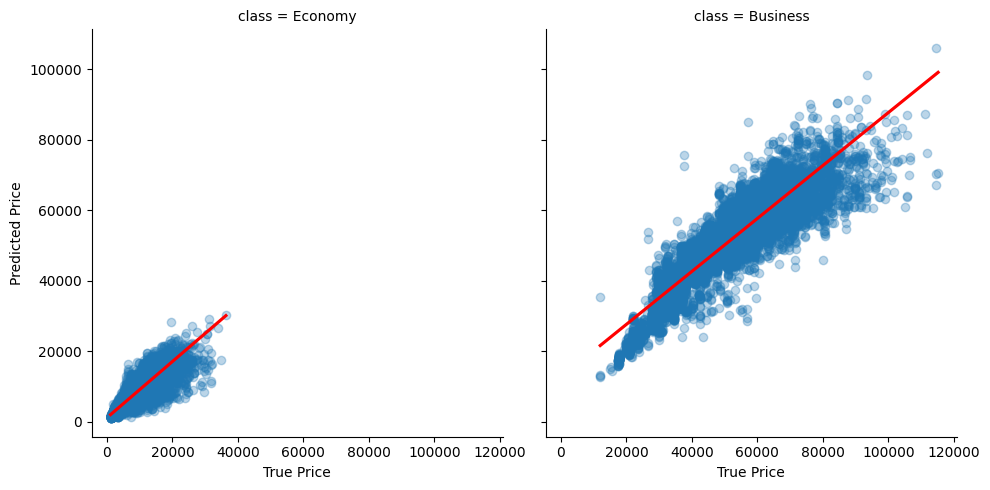

In [44]:
sns.lmplot(data = comparison, x = "True Price", y = "Predicted Price", scatter_kws={"alpha": 0.3}, line_kws={"color": "r"}, col= "class")